# Vision-based Pose Estimator: demo

This notebook demonstrates: 
- how to load the MH_01_easy dataset using the provided `pose_train` utilities,
- run a single forward pass through the model (small CNN or ResNet backbone), and
- run a short validation inference to visualize predicted vs ground-truth poses.

Adjust the cells below if you want to run a longer training session or evaluate on different cameras.

In [1]:
# Setup: imports and paths
import sys
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np

# make sure the package path is visible (adjust path if needed)
project_root = Path('c:/Users/cheta/Downloads/MH_01_easy/mav0').resolve()
sys.path.append(str(project_root))

from pose_train.dataset import MAVPoseDataset
from pose_train.model import SimplePoseNet
from pose_train.train import pose_loss

print('torch', torch.__version__)
print('project root', project_root)

torch 2.8.0+cpu
project root C:\Users\cheta\Downloads\MH_01_easy\mav0


In [2]:
# Preview one sample and run a forward pass
data_root = project_root
cams = ['cam0']
ds = MAVPoseDataset(data_root, cams=cams)
print('dataset length:', len(ds))
img, pose = ds[0]
print('image shape', img.shape)
print('pose', pose.numpy())

# create model (use 'small' or 'resnet18')
model = SimplePoseNet(in_channels=len(cams), backbone='resnet18', pretrained=False)
model.eval()
with torch.no_grad():
    x = img.unsqueeze(0)
    out = model(x)
    loss, lt, lr = pose_loss(out, pose.unsqueeze(0))
    print('out shape', out.shape, 'loss', loss.item())

dataset length: 3640
image shape torch.Size([1, 240, 320])
pose [ 4.688319   -1.786938    0.783338    0.5341078  -0.15302894 -0.8273827
 -0.08215197]
out shape torch.Size([1, 7]) loss 9.871048927307129


C:\Users\cheta\Downloads\MH_01_easy\mav0\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cheta\Downloads\MH_01_easy\mav0\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


preds shape (364, 7) gts shape (364, 7)


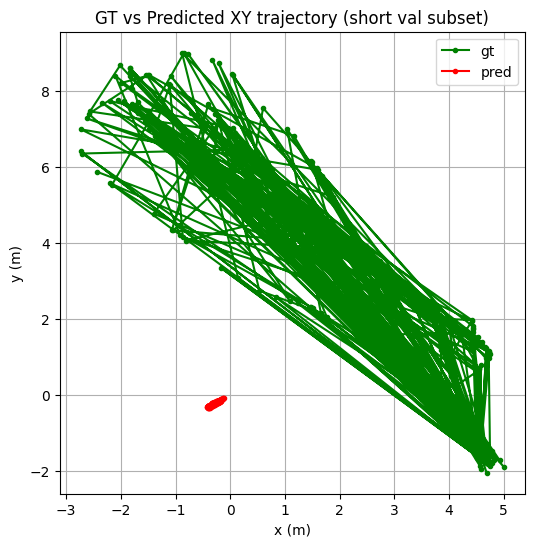

translation RMSE (m): 5.7277384


In [3]:
# Short inference over a small validation split and visualization
from torch.utils.data import random_split, DataLoader

val_size = max(1, int(len(ds) * 0.1))
train_size = len(ds) - val_size
_, val_ds = random_split(ds, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
preds = []
gts = []
with torch.no_grad():
    for imgs, poses in val_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds.append(out.cpu().numpy())
        gts.append(poses.numpy())

preds = np.vstack(preds)
gts = np.vstack(gts)
print('preds shape', preds.shape, 'gts shape', gts.shape)

# plot X,Y trajectory comparison (ground-truth vs predicted)
plt.figure(figsize=(6,6))
plt.plot(gts[:,0], gts[:,1], 'g.-', label='gt')
plt.plot(preds[:,0], preds[:,1], 'r.-', label='pred')
plt.legend()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('GT vs Predicted XY trajectory (short val subset)')
plt.grid(True)
plt.show()

# print simple ATE-like metric (translation RMSE)
trans_err = np.linalg.norm(preds[:, :3] - gts[:, :3], axis=1)
print('translation RMSE (m):', np.sqrt((trans_err ** 2).mean()))